# 前言

**本文参照特征工程这本书，完整地完成一套流程**

# 加载数据

In [420]:
import pandas as pd
import os

In [2]:
# 过滤掉一些警告
import warnings
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [307]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (AdaBoostClassifier, RandomForestClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [306]:
import xgboost as xgb

In [305]:
!pip install xgboost

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
     |████████████████████████████████| 127.6 MB 17 kB/s  eta 0:00:01��████▎                       | 33.1 MB 366 kB/s eta 0:04:18kB/s eta 0:03:43      | 58.6 MB 426 kB/s eta 0:02:42/s eta 0:02:46:01:35 | 105.6 MB 423 kB/s eta 0:00:52��████████▊    | 110.5 MB 3.2 MB/s eta 0:00:06��███████████████████▌   | 113.7 MB 4.8 MB/s eta 0:00:03    |█████████████████████████████▌  | 117.5 MB 443 kB/s eta 0:00:230 MB 425 kB/s eta 0:00:169 MB 358 kB/s eta 0:00:11███████▍| 125.2 MB 358 kB/s eta 0:00:07


In [5]:
# 准备进行网格搜索
# CV表示交叉验证 cross validation
from sklearn.model_selection import GridSearchCV  

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [7]:
from sklearn.preprocessing import LabelEncoder

In [191]:
from sklearn.model_selection import KFold

In [8]:
import numpy as np

In [9]:
os.listdir()

['test.csv',
 'README.md',
 'gender_submission.csv',
 '1. Titanic数据预处理.ipynb',
 '.ipynb_checkpoints',
 'train.csv',
 '参照特征工程入门这本书.ipynb',
 '.git',
 '参考另一个.ipynb']

In [10]:
train = pd.read_csv('train.csv')

In [11]:
test = pd.read_csv('test.csv')

# 数据预处理

这部分主要完成数据的缺失值填充

In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [14]:
train.isnull().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

****
从这里可以看出 Age Cabin Embarked是有缺失值的

所以需要填充这些缺失值。但Cabin的缺失值太多，我们先丢弃这一列

In [15]:
train.drop('Cabin', axis=1, inplace=True)

Age 是定量数据

Embarked 是定类数据

- 定类数据用众数填充缺失值
- 定量数据用中位数或者平均数填充缺失值

In [16]:
train['Age'].fillna(train.Age.median(), inplace=True)
train['Embarked'].fillna(train.Embarked.mode()[0], inplace=True)

In [17]:
# abs可以发现缺失值填充完成
train.isnull().mean()

PassengerId    0.0
Survived       0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Embarked       0.0
dtype: float64

In [18]:
columns_list = train.columns.tolist()

In [19]:
columns_list

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Embarked']

# 特征理解

## 特征等级说明

****
**这一部分主要是对数据类型进行理解，数据首先可以分成 定性数据和定量数据**

**定量数据：本质上是数值，描述一个特征的数量**

**定性数据：本质上是类别，描述一个特征的种类**
****

**定性数据：pclass，name，sex，ticked，pclass**

**定量数据：age，sibsp，parch，fare**
****

然而还可以继续进行分类，定性数据还可以分成：

- 定类等级
- 定序等级
- 定距等级
- 定比等级

定类等级：如性别，就是分成男性和女性

定序等级：pclass，虽然也是类别，但我们希望某些类别数值越大越好。如不喜欢，一般，喜欢三个层度

定距等级：主要是针对定量数据。但和定序数据类似。不仅可以对数据进行排序，还可以数据进行加减。如温度。这类数据要用直方图查看

定比等级：定比等级还可以进行乘除运算。

****
定类等级：survived，name，sex，ticked

定序等级：pclass

定距等级：sibsp，parch

定比等级：age，fare

## 特征等级的图像描述方法

**定距等级和定比等级可以用直方图来描述。不能用饼状图或者是条形图来描述**

**定类等级和定序等级可以使用条形图描述**

(array([ 54.,  46., 177., 346., 118.,  70.,  45.,  24.,   9.,   2.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <BarContainer object of 10 artists>)

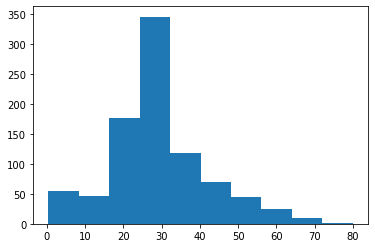

In [20]:
plt.hist(train.Age)

**数据形状类似于正太分布，其实只要数据大到一定层度。按统计学规律。是一定会呈现出正太分布的形式的**

(array([732., 106.,  31.,   2.,  11.,   6.,   0.,   0.,   0.,   3.]),
 array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
        307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]),
 <BarContainer object of 10 artists>)

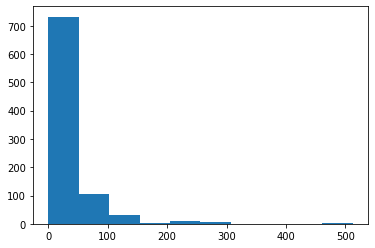

In [21]:
plt.hist(train.Fare)

**对定类数据使用条形图来观察**

<AxesSubplot:>

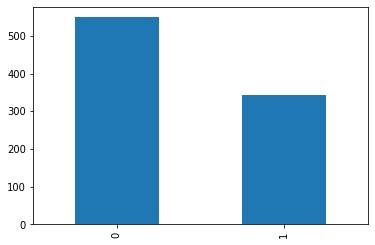

In [22]:
train.Survived.value_counts().plot(kind='bar')

<AxesSubplot:ylabel='Survived'>

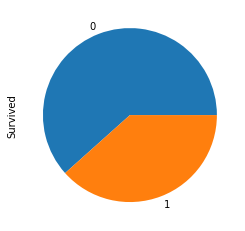

In [23]:
train.Survived.value_counts().plot(kind='pie')

# 特征增强

观察下Name和Ticket这两个特征。似乎都不能使用

In [24]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [25]:
train['Name'].nunique()

891

In [26]:
train['Ticket'].nunique()

681

In [27]:
train['New_name'] = train['Name'].str.extract(', (\w+).')

In [28]:
train.drop('Ticket', axis=1, inplace=True)

In [29]:
new_data_column = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'New_name']

In [30]:
new_data = train[new_data_column]

In [31]:
new_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,New_name
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


In [32]:
temp = new_data['New_name'].value_counts()

In [33]:
temp.loc['Mr']

517

In [34]:
new_data.loc[:,'New_name'] = new_data.loc[:,'New_name'].apply(
    lambda x:'Misc' if temp[x] < 10 else x
)

使用10作为分界线，否则认为出现的频率很低，因此归一类

In [35]:
new_data['New_name'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: New_name, dtype: int64

In [36]:
new_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,New_name
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


## 相关性分析

<AxesSubplot:>

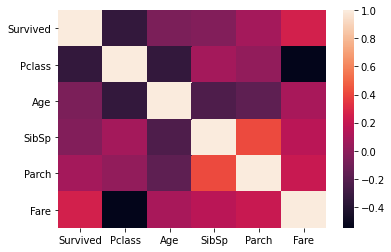

In [37]:
sns.heatmap(new_data.corr())

In [38]:
new_data.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'New_name'],
      dtype='object')

In [39]:
new_data.corr()['Survived']

Survived    1.000000
Pclass     -0.338481
Age        -0.064910
SibSp      -0.035322
Parch       0.081629
Fare        0.257307
Name: Survived, dtype: float64

为什么少了这么多变量？不是还有性别和姓名这些属性吗。怎么没显示出来

这是因为这些数据都是字符串类型

In [40]:
# 将定类数据进行one hot编码。也就是哑变量
# 因为我们不希望这些分类数据有强度之分，也就是不喜欢，喜欢这样的差别
train1 = pd.get_dummies(new_data, columns=['Sex', 'Embarked', 'New_name'])
del new_data

<AxesSubplot:>

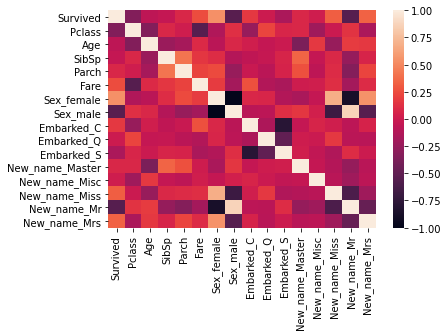

In [41]:
sns.heatmap(train1.corr())

In [42]:
# 进行排序好

train1.corr()['Survived'].sort_values(ascending=False)

Survived           1.000000
Sex_female         0.543351
New_name_Mrs       0.339040
New_name_Miss      0.327093
Fare               0.257307
Embarked_C         0.168240
New_name_Master    0.085221
Parch              0.081629
New_name_Misc      0.022030
Embarked_Q         0.003650
SibSp             -0.035322
Age               -0.064910
Embarked_S        -0.149683
Pclass            -0.338481
Sex_male          -0.543351
New_name_Mr       -0.549199
Name: Survived, dtype: float64

**从现在的相关性分析可以看出 相关系数小于正负0.1的似乎相关性都不高。到时候我们剔除这些特征再分析一下看下效果**

In [43]:
train1.Survived.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

假如我们全猜0的话，准确率也有0.6。这叫做空准确率。所以接下来的模型准确率。一定要高于这个数字

# 模型预测

接下来我们将初步利用上面的数据来训练模型，看下准确率

## 训练模型

In [44]:
MODEL = [
#     AdaBoostClassifier(), 
    RandomForestClassifier(), 
    LogisticRegressionCV(), 
    BernoulliNB(), 
    GaussianNB(), 
    SVC(), 
    DecisionTreeClassifier()
]

In [45]:
train1.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,New_name_Master,New_name_Misc,New_name_Miss,New_name_Mr,New_name_Mrs
0,0,3,22.0,1,0,7.2500,0,1,0,0,1,0,0,0,1,0
1,1,1,38.0,1,0,71.2833,1,0,1,0,0,0,0,0,0,1
2,1,3,26.0,0,0,7.9250,1,0,0,0,1,0,0,1,0,0
3,1,1,35.0,1,0,53.1000,1,0,0,0,1,0,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1,0,0,0,1,0


In [46]:
x, y = train1.drop('Survived', axis=1), train1['Survived']

In [95]:
# 查看内置的属性
# dir(DecisionTreeClassifier())

In [48]:
DecisionTreeClassifier().__class__

sklearn.tree._classes.DecisionTreeClassifier

In [49]:
def modeling(model_list, x, y):
    d = {}
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2020)
    for model in model_list:
        model.fit(x_train, y_train)
        score = model.score(x_test, y_test)
#         print(f'{model.__class__} : {score}')
        d[model.__class__] = score # 获得属性的名字
    print(pd.Series(d).sort_values(ascending=False))

modeling(MODEL, x, y)

<class 'sklearn.linear_model._logistic.LogisticRegressionCV'>    0.825112
<class 'sklearn.ensemble._forest.RandomForestClassifier'>        0.811659
<class 'sklearn.naive_bayes.GaussianNB'>                         0.798206
<class 'sklearn.naive_bayes.BernoulliNB'>                        0.766816
<class 'sklearn.tree._classes.DecisionTreeClassifier'>           0.757848
<class 'sklearn.svm._classes.SVC'>                               0.632287
dtype: float64


**从上面的结果可以看出，逻辑回归和随机森林的效果似乎还不错。这还是在没有调节参数的情况下**

下面使用网格搜索进行调参

## 网格搜索

**TODO**

1. 上面不是进行了一些相关性分析吗，看看删除一些特征准确率的变化情况
2. 使用网格搜索，查找最佳参数，提升模型的准确度

In [50]:
# help(LogisticRegressionCV)

In [51]:
model_param_dict = {
# 'LogisticRegressionCV'
    0:{
    'penalty':['l1','l2','elasticnet'],
    'solver':['newton-cg', 'lbfgs','liblinear','sag','saga'],
    'class_weight':['balance',None],
#     'cv':[2,3,4],
},

# 'RandomForestClassifier'
    1:{
    'n_estimators':[90,100,110],
    'criterion':['gini','entropy'],
    'max_depth':[i for i in range(15)],
    'min_samples_split':[i for i in range(5)],
    'class_weight':['balanced', 'balanced_subsample'],
},

# GaussianNB_param = {}

# BernoulliNB_param = {   }

# 'DecisionTreeClassifier'
    2:{
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':[i for i in range(5,15)],
    'min_samples_split':[i for i in range(5)],
#     'minz_samples_leaf':[i for i in range(5)],
    'max_features':['auto', 'sqrt', 'log2'],
    'class_weight':['balanced',None],
    
},
}

In [94]:
model_list = [
    LogisticRegressionCV(),
    RandomForestClassifier(), 
    DecisionTreeClassifier(),
]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2020)
for num, model in enumerate(model_list):
    gscv = GridSearchCV(model, param_grid=model_param_dict[num], cv=2, n_jobs=-1)
    gscv.fit(x_train,y_train)
    score = gscv.score(x_test,y_test)
    print(model)
    print(gscv.best_params_)
    print(score)
    print('-'*20)

LogisticRegressionCV()
{'class_weight': 'balance', 'penalty': 'l1', 'solver': 'liblinear'}
0.8251121076233184
--------------------
RandomForestClassifier()
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 90}
0.8251121076233184
--------------------
DecisionTreeClassifier()
{'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'min_samples_split': 4, 'splitter': 'random'}
0.757847533632287
--------------------


## 去掉相关性比较差的特征

In [121]:
temp = abs(train1.corr()['Survived']) > 0.02
# 注意有些相关系数是小于0的

In [116]:
temp

Survived            True
Pclass              True
Age                 True
SibSp               True
Parch               True
Fare                True
Sex_female          True
Sex_male            True
Embarked_C          True
Embarked_Q         False
Embarked_S          True
New_name_Master     True
New_name_Misc       True
New_name_Miss       True
New_name_Mr         True
New_name_Mrs        True
Name: Survived, dtype: bool

In [117]:
type(temp)

pandas.core.series.Series

In [118]:
temp_list = temp.index.to_list()

In [119]:
res = [i for i in temp_list if temp[i]]

In [120]:
res

['Survived',
 'Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_S',
 'New_name_Master',
 'New_name_Misc',
 'New_name_Miss',
 'New_name_Mr',
 'New_name_Mrs']

In [122]:
train4 = train1[res]

In [123]:
res.pop(0)
x4, y4 = train4[res], train4['Survived']


def modeling(model_list, x, y):
    d = {}
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2020)
    for model in model_list:
        model.fit(x_train, y_train)
        score = model.score(x_test, y_test)
#         print(f'{model.__class__} : {score}')
        d[model.__class__] = score # 获得属性的名字
    print(pd.Series(d).sort_values(ascending=False))

modeling(MODEL, x4, y4)

<class 'sklearn.linear_model._logistic.LogisticRegressionCV'>    0.820628
<class 'sklearn.ensemble._forest.RandomForestClassifier'>        0.816143
<class 'sklearn.naive_bayes.GaussianNB'>                         0.793722
<class 'sklearn.naive_bayes.BernoulliNB'>                        0.766816
<class 'sklearn.tree._classes.DecisionTreeClassifier'>           0.744395
<class 'sklearn.svm._classes.SVC'>                               0.632287
dtype: float64


## 总结

**在前面部分中，对数据的处理有以下方法：**
- 单独就是对定序等级的数据进行了one hot形式处理
- 年龄和船票价格都是连续的。暂时没有离散化处理
- 跑了下模型，进行了下网格搜索

网格搜索似乎只有一点点帮助，但效果没有很明显

当去除掉相关性比较低的特征以后，随机森林的模型精确度反而上升了，其他的模型准确度略微有点下降，但模型的拟合速度得到了很大的提升

# 提升模型

**接下来考虑创造一些特征，来提升模型的准确度。同时也会考虑模型融合**

## 尝试归一化

年龄和船票价格对其他变量的影响比较大。所以试一试将这两行数据进行归一化。看看模型的准确率有没有提升

In [53]:
train2 = train1.copy()

In [54]:
train2 is train1

# 这里注意和==的区别。is是判断两个变量指向的id是不是一样

False

In [55]:
train2.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,New_name_Master,New_name_Misc,New_name_Miss,New_name_Mr,New_name_Mrs
0,0,3,22.0,1,0,7.2500,0,1,0,0,1,0,0,0,1,0
1,1,1,38.0,1,0,71.2833,1,0,1,0,0,0,0,0,0,1
2,1,3,26.0,0,0,7.9250,1,0,0,0,1,0,0,1,0,0
3,1,1,35.0,1,0,53.1000,1,0,0,0,1,0,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1,0,0,0,1,0


In [56]:
min_max = MinMaxScaler()
min_max_data = pd.DataFrame(min_max.fit_transform(train2[['Age', 'Fare']]), columns=['Age_scaler', 'Fare_scaler'])

In [57]:
train2 = pd.concat([train2, min_max_data], axis=1).drop(['Age','Fare'], axis=1)

In [58]:
train2.head()

,Survived,Pclass,SibSp,Parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,New_name_Master,New_name_Misc,New_name_Miss,New_name_Mr,New_name_Mrs,Age_scaler,Fare_scaler
0,0,3,1,0,0,1,0,0,1,0,0,0,1,0,0.271174,0.014151
1,1,1,1,0,1,0,1,0,0,0,0,0,0,1,0.472229,0.139136
2,1,3,0,0,1,0,0,0,1,0,0,1,0,0,0.321438,0.015469
3,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0.434531,0.103644
4,0,3,0,0,0,1,0,0,1,0,0,0,1,0,0.434531,0.015713


In [59]:
x2, y2 = train2.drop('Survived', axis=1), train2['Survived']

In [60]:
def modeling(model_list, x, y):
    d = {}
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2020)
    for model in model_list:
        model.fit(x_train, y_train)
        score = model.score(x_test, y_test)
#         print(f'{model.__class__} : {score}')
        d[model.__class__] = score # 获得属性的名字
    print(pd.Series(d).sort_values(ascending=False))

modeling(MODEL, x2, y2)

<class 'sklearn.svm._classes.SVC'>                               0.834081
<class 'sklearn.linear_model._logistic.LogisticRegressionCV'>    0.807175
<class 'sklearn.ensemble._forest.RandomForestClassifier'>        0.807175
<class 'sklearn.naive_bayes.GaussianNB'>                         0.798206
<class 'sklearn.naive_bayes.BernoulliNB'>                        0.766816
<class 'sklearn.tree._classes.DecisionTreeClassifier'>           0.753363
dtype: float64


<class 'sklearn.linear_model._logistic.LogisticRegressionCV'>    0.825112

<class 'sklearn.ensemble._forest.RandomForestClassifier'>        0.816143

<class 'sklearn.naive_bayes.GaussianNB'>                         0.798206

<class 'sklearn.naive_bayes.BernoulliNB'>                        0.766816

<class 'sklearn.tree._classes.DecisionTreeClassifier'>           0.753363

<class 'sklearn.svm._classes.SVC'>                               0.632287

**数据进行归一化后，svm的效果更好点。变化很大。我们单独对svm进行网格搜索。看看模型上限是多少**

In [61]:
grid_param = {
    'C':np.linspace(0,2,20),
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'degree':[i for i in range(5)],
    'gamma':['scale', 'auto'],
}

In [62]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size = 0.3, random_state=2020)

In [63]:
grid_search = GridSearchCV(SVC(), param_grid=grid_param, n_jobs=4)
grid_search.fit(x2_train, y2_train)
score = grid_search.score(x2_test, y2_test)
print(score)
print(grid_search.best_params_)

0.8395522388059702
{'C': 0.8421052631578947, 'degree': 0, 'gamma': 'scale', 'kernel': 'rbf'}


**模型精度只提升了一点点**

## 连续数据离散化

TODO:

1. 尝试创建新的特征
2. 对年龄和票价进行分类处理。设置成定序等级

In [64]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,New_name
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


In [65]:
train1.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,New_name_Master,New_name_Misc,New_name_Miss,New_name_Mr,New_name_Mrs
0,0,3,22.0,1,0,7.2500,0,1,0,0,1,0,0,0,1,0
1,1,1,38.0,1,0,71.2833,1,0,1,0,0,0,0,0,0,1
2,1,3,26.0,0,0,7.9250,1,0,0,0,1,0,0,1,0,0
3,1,1,35.0,1,0,53.1000,1,0,0,0,1,0,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1,0,0,0,1,0


我们试试将年龄和性别按区间分好。设置成定序数据

(array([ 54.,  46., 177., 346., 118.,  70.,  45.,  24.,   9.,   2.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <BarContainer object of 10 artists>)

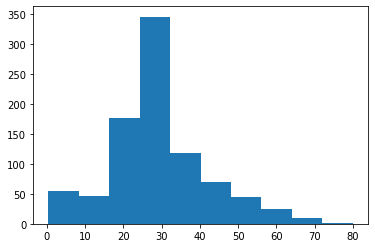

In [66]:
plt.hist(train1.Age)

(array([732., 106.,  31.,   2.,  11.,   6.,   0.,   0.,   0.,   3.]),
 array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
        307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]),
 <BarContainer object of 10 artists>)

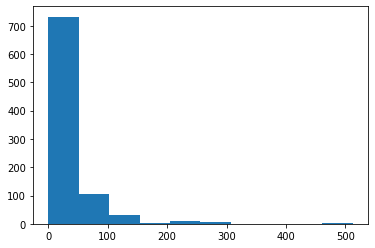

In [67]:
plt.hist(train1.Fare)

Fare有很严重的不均衡情况。即某类的数据很多。其他几类数据很少

****
**cut and qcut**

cut:根据等距离原则，将每个数据进行分类

qcut:根据数据出现的频率进行区间划分，尽量保证每个区间的数据量相同

- 在下面数据处理中，我们对年龄进行cut划分。我们认为10-20为少年，20-30为青年这样
- 对于不是上面类型的数据。我们使用qcut。使样本更均衡

In [68]:
train1['FareBin'] = pd.qcut(train1.Fare,5)

In [69]:
train1['AgeBin'] = pd.cut(train1.Age, 5)

<AxesSubplot:>

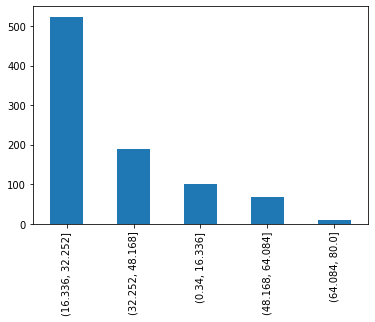

In [70]:
train1['AgeBin'].value_counts().plot(kind='bar')

In [71]:
train3 = train1.drop(['Age','Fare'], axis=1)

In [72]:
train3.head()

,Survived,Pclass,SibSp,Parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,New_name_Master,New_name_Misc,New_name_Miss,New_name_Mr,New_name_Mrs,FareBin,AgeBin
0,0,3,1,0,0,1,0,0,1,0,0,0,1,0,"(-0.001, 7.854]","(16.336, 32.252]"
1,1,1,1,0,1,0,1,0,0,0,0,0,0,1,"(39.688, 512.329]","(32.252, 48.168]"
2,1,3,0,0,1,0,0,0,1,0,0,1,0,0,"(7.854, 10.5]","(16.336, 32.252]"
3,1,1,1,0,1,0,0,0,1,0,0,0,0,1,"(39.688, 512.329]","(32.252, 48.168]"
4,0,3,0,0,0,1,0,0,1,0,0,0,1,0,"(7.854, 10.5]","(32.252, 48.168]"


In [73]:
train3[['Survived', 'AgeBin']].groupby('AgeBin').mean()

,Survived
AgeBin,
"(0.34, 16.336]",0.550000
"(16.336, 32.252]",0.344168
"(32.252, 48.168]",0.404255
"(48.168, 64.084]",0.434783
"(64.084, 80.0]",0.090909


In [74]:
train3[['Survived', 'FareBin']].groupby('FareBin').mean()

,Survived
FareBin,
"(-0.001, 7.854]",0.217877
"(7.854, 10.5]",0.201087
"(10.5, 21.679]",0.424419
"(21.679, 39.688]",0.444444
"(39.688, 512.329]",0.642045


In [75]:
train1.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,New_name_Master,New_name_Misc,New_name_Miss,New_name_Mr,New_name_Mrs,FareBin,AgeBin
0,0,3,22.0,1,0,7.2500,0,1,0,0,1,0,0,0,1,0,"(-0.001, 7.854]","(16.336, 32.252]"
1,1,1,38.0,1,0,71.2833,1,0,1,0,0,0,0,0,0,1,"(39.688, 512.329]","(32.252, 48.168]"
2,1,3,26.0,0,0,7.9250,1,0,0,0,1,0,0,1,0,0,"(7.854, 10.5]","(16.336, 32.252]"
3,1,1,35.0,1,0,53.1000,1,0,0,0,1,0,0,0,0,1,"(39.688, 512.329]","(32.252, 48.168]"
4,0,3,35.0,0,0,8.0500,0,1,0,0,1,0,0,0,1,0,"(7.854, 10.5]","(32.252, 48.168]"


In [76]:
train1.Age.dtypes

dtype('float64')

In [77]:
def func_age(x):
    if x > 64:
        x = 0
    elif 16 < x <= 32:
        x = 1
    elif 32 < x <= 48:
        x = 2
    elif 48 < x <= 64:
        x = 3
    else:
        x = 5
    return x # 注意这里要return x

train3['Age_code'] = train1.Age.apply(func_age)

In [78]:
def func_fare(x):
    if 7 < x <= 10:
        x = 0
    elif x <= 7:
        x = 1
    elif 10 < x <= 21:
        x = 2
    elif 21 < x <= 39:
        x = 3
    else:
        x = 4
    return x

train3['Fare_code'] = train1.Fare.apply(func_fare)

In [79]:
coder = LabelEncoder()

train3['Fare_labelcode'] = coder.fit_transform(train3.FareBin)
train3['Age_labelcode'] = coder.fit_transform(train3.AgeBin)

In [80]:
train3[['Survived', 'Fare_labelcode']].groupby('Fare_labelcode').mean()

,Survived
Fare_labelcode,
0,0.217877
1,0.201087
2,0.424419
3,0.444444
4,0.642045


由此知道，LabelEncoder就是按顺序进行编号。我们先跑准确率。再测试按程度编号效果怎么样

## 模型测试

我们目前只是将年龄和票价离散化处理了。等下尝试创建一些新的特征。先测试下模型效果怎么样

In [81]:
train3.head()

,Survived,Pclass,SibSp,Parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,New_name_Master,New_name_Misc,New_name_Miss,New_name_Mr,New_name_Mrs,FareBin,AgeBin,Age_code,Fare_code,Fare_labelcode,Age_labelcode
0,0,3,1,0,0,1,0,0,1,0,0,0,1,0,"(-0.001, 7.854]","(16.336, 32.252]",1,0,0,1
1,1,1,1,0,1,0,1,0,0,0,0,0,0,1,"(39.688, 512.329]","(32.252, 48.168]",2,4,4,2
2,1,3,0,0,1,0,0,0,1,0,0,1,0,0,"(7.854, 10.5]","(16.336, 32.252]",1,0,1,1
3,1,1,1,0,1,0,0,0,1,0,0,0,0,1,"(39.688, 512.329]","(32.252, 48.168]",2,4,4,2
4,0,3,0,0,0,1,0,0,1,0,0,0,1,0,"(7.854, 10.5]","(32.252, 48.168]",2,0,1,2


In [82]:
x3, y3 = train3.drop(['Survived', 'AgeBin', 'FareBin'], axis=1), train3['Survived']
# 这里要剔除掉AgeBin这些是因为这两个都不是category类。运行下面程序会报错

In [83]:
def modeling(model_list, x, y):
    d = {}
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2020)
    for model in model_list:
        model.fit(x_train, y_train)
        score = model.score(x_test, y_test)
#         print(f'{model.__class__} : {score}')
        d[model.__class__] = score # 获得属性的名字
    print(pd.Series(d).sort_values(ascending=False))


modeling(MODEL, x3, y3)

<class 'sklearn.linear_model._logistic.LogisticRegressionCV'>    0.834081
<class 'sklearn.ensemble._forest.RandomForestClassifier'>        0.820628
<class 'sklearn.svm._classes.SVC'>                               0.811659
<class 'sklearn.naive_bayes.GaussianNB'>                         0.784753
<class 'sklearn.tree._classes.DecisionTreeClassifier'>           0.780269
<class 'sklearn.naive_bayes.BernoulliNB'>                        0.775785
dtype: float64


****
这里和之前没有离散化年龄和票价的情况下进行对比

<class 'sklearn.svm._classes.SVC'>                               0.834081

<class 'sklearn.linear_model._logistic.LogisticRegressionCV'>    0.807175

<class 'sklearn.ensemble._forest.RandomForestClassifier'>        0.807175

<class 'sklearn.naive_bayes.GaussianNB'>                         0.798206

<class 'sklearn.naive_bayes.BernoulliNB'>                        0.766816

<class 'sklearn.tree._classes.DecisionTreeClassifier'>           0.744395

In [84]:
model_param_dict = {
# 'LogisticRegressionCV'
    0:{
    'penalty':['l1','l2','elasticnet'],
    'solver':['newton-cg', 'lbfgs','liblinear','sag','saga'],
    'class_weight':['balance',None],
#     'cv':[2,3,4],
},

# 'RandomForestClassifier'
    1:{
    'n_estimators':[90,100,110],
    'criterion':['gini','entropy'],
    'max_depth':[i for i in range(15)],
    'min_samples_split':[i for i in range(5)],
    'class_weight':['balanced', 'balanced_subsample'],
},

# GaussianNB_param = {}

# BernoulliNB_param = {   }

# 'DecisionTreeClassifier'
    2:{
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':[i for i in range(5,15)],
    'min_samples_split':[i for i in range(5)],
#     'minz_samples_leaf':[i for i in range(5)],
    'max_features':['auto', 'sqrt', 'log2'],
    'class_weight':['balanced',None],
    
},
    3:{
    'C':np.linspace(0,2,20),
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'degree':[i for i in range(5)],
    'gamma':['scale', 'auto'],
    }
}

In [85]:
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, test_size=.3, random_state=2020)

In [86]:
model_list = [
    LogisticRegressionCV(),
    RandomForestClassifier(), 
    DecisionTreeClassifier(),
    SVC(),
]

for num, model in enumerate(model_list):
    gscv = GridSearchCV(model, param_grid=model_param_dict[num], cv=2, n_jobs=-1)
    gscv.fit(x3_train,y3_train)
    score = gscv.score(x3_test,y3_test)
    print(model)
    print(gscv.best_params_)
    print(score)
    print('-'*20)

LogisticRegressionCV()
{'class_weight': 'balance', 'penalty': 'l1', 'solver': 'liblinear'}
0.835820895522388
--------------------
RandomForestClassifier()
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 90}
0.8022388059701493
--------------------
DecisionTreeClassifier()
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 3, 'splitter': 'best'}
0.7798507462686567
--------------------
SVC()
{'C': 0.21052631578947367, 'degree': 0, 'gamma': 'scale', 'kernel': 'linear'}
0.8246268656716418
--------------------


LogisticRegressionCV() 0.8251121076233184

RandomForestClassifier() 0.820627802690583

DecisionTreeClassifier() 0.7802690582959642

<class 'sklearn.svm._classes.SVC'> 0.834081

看来还是之前的svc效果比较好，这里的svc是没有离散化的情况下

****
**上面的情况是使用label encoder的效果。接下来是我自己使用分类的效果。附带了程度。即生存率越高。则数值越大**

In [87]:
train3.head()

,Survived,Pclass,SibSp,Parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,New_name_Master,New_name_Misc,New_name_Miss,New_name_Mr,New_name_Mrs,FareBin,AgeBin,Age_code,Fare_code,Fare_labelcode,Age_labelcode
0,0,3,1,0,0,1,0,0,1,0,0,0,1,0,"(-0.001, 7.854]","(16.336, 32.252]",1,0,0,1
1,1,1,1,0,1,0,1,0,0,0,0,0,0,1,"(39.688, 512.329]","(32.252, 48.168]",2,4,4,2
2,1,3,0,0,1,0,0,0,1,0,0,1,0,0,"(7.854, 10.5]","(16.336, 32.252]",1,0,1,1
3,1,1,1,0,1,0,0,0,1,0,0,0,0,1,"(39.688, 512.329]","(32.252, 48.168]",2,4,4,2
4,0,3,0,0,0,1,0,0,1,0,0,0,1,0,"(7.854, 10.5]","(32.252, 48.168]",2,0,1,2


In [88]:
x3, y3 = train3.drop(['Survived', 'AgeBin', 'FareBin'], axis=1), train3.Survived

In [89]:
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, test_size=.3, random_state=2020)

In [90]:
model_list = [
    LogisticRegressionCV(),
    RandomForestClassifier(), 
    DecisionTreeClassifier(),
    SVC(),
]

for num, model in enumerate(model_list):
    gscv = GridSearchCV(model, param_grid=model_param_dict[num], cv=2, n_jobs=-1)
    gscv.fit(x3_train,y3_train)
    score = gscv.score(x3_test,y3_test)
    print(model)
    print(gscv.best_params_)
    print(score)
    print('-'*20)

LogisticRegressionCV()
{'class_weight': 'balance', 'penalty': 'l1', 'solver': 'liblinear'}
0.835820895522388
--------------------
RandomForestClassifier()
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 110}
0.8134328358208955
--------------------
DecisionTreeClassifier()
{'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 4, 'splitter': 'random'}
0.8022388059701493
--------------------
SVC()
{'C': 0.21052631578947367, 'degree': 0, 'gamma': 'scale', 'kernel': 'linear'}
0.8246268656716418
--------------------


## 中期总结

**前面船票和年龄这两类数据都是连续的，并没有对数据进行归一化处理，归一化处理后：svm的准确度达到了最高0.839**

**将数据进行离散化处理后，svm的效果反而下降了，但是其他模型的准确度却有所提升**

**尝试了使用Labelencoder进行定距等级。这个模块是按顺序的。没有体现不喜欢是0。所以自己尝试了按定序等级程度编号，效果提升不明显**

## 创建新的特征

In [91]:
train3.drop(['AgeBin', 'FareBin'], axis=1, inplace=True)

In [92]:
train3.head()

,Survived,Pclass,SibSp,Parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,New_name_Master,New_name_Misc,New_name_Miss,New_name_Mr,New_name_Mrs,Age_code,Fare_code,Fare_labelcode,Age_labelcode
0,0,3,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1
1,1,1,1,0,1,0,1,0,0,0,0,0,0,1,2,4,4,2
2,1,3,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,1
3,1,1,1,0,1,0,0,0,1,0,0,0,0,1,2,4,4,2
4,0,3,0,0,0,1,0,0,1,0,0,0,1,0,2,0,1,2


TODO

- 接下来创建一些新的特征

In [93]:
train1.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,New_name_Master,New_name_Misc,New_name_Miss,New_name_Mr,New_name_Mrs,FareBin,AgeBin
0,0,3,22.0,1,0,7.2500,0,1,0,0,1,0,0,0,1,0,"(-0.001, 7.854]","(16.336, 32.252]"
1,1,1,38.0,1,0,71.2833,1,0,1,0,0,0,0,0,0,1,"(39.688, 512.329]","(32.252, 48.168]"
2,1,3,26.0,0,0,7.9250,1,0,0,0,1,0,0,1,0,0,"(7.854, 10.5]","(16.336, 32.252]"
3,1,1,35.0,1,0,53.1000,1,0,0,0,1,0,0,0,0,1,"(39.688, 512.329]","(32.252, 48.168]"
4,0,3,35.0,0,0,8.0500,0,1,0,0,1,0,0,0,1,0,"(7.854, 10.5]","(32.252, 48.168]"


****

创建两个新的特征：
1. 家庭大小
2. 是否是一个人

In [124]:
temp = train1['SibSp'] + train1['Parch']

In [126]:
temp.value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
dtype: int64

In [127]:
del train4
train4 = train1.copy()
train4['Family_size'] = temp

In [129]:
# 如果是一个人则是1 否则就是0
train4['IsAlone'] = train4['Family_size'].apply(lambda x: 0 if x else 1)

In [130]:
train4.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,New_name_Master,New_name_Misc,New_name_Miss,New_name_Mr,New_name_Mrs,FareBin,AgeBin,Family_size,IsAlone
0,0,3,22.0,1,0,7.2500,0,1,0,0,1,0,0,0,1,0,"(-0.001, 7.854]","(16.336, 32.252]",1,0
1,1,1,38.0,1,0,71.2833,1,0,1,0,0,0,0,0,0,1,"(39.688, 512.329]","(32.252, 48.168]",1,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1,0,0,1,0,0,"(7.854, 10.5]","(16.336, 32.252]",0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1,0,0,0,0,1,"(39.688, 512.329]","(32.252, 48.168]",1,0
4,0,3,35.0,0,0,8.0500,0,1,0,0,1,0,0,0,1,0,"(7.854, 10.5]","(32.252, 48.168]",0,1


In [ ]:
del x4,y4

In [134]:
x4, y4 = train4.drop(['Survived', 'FareBin', 'AgeBin'], axis=1), train4['Survived']

没有归一化处理

In [135]:
def modeling(model_list, x, y):
    d = {}
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2020)
    for model in model_list:
        model.fit(x_train, y_train)
        score = model.score(x_test, y_test)
#         print(f'{model.__class__} : {score}')
        d[model.__class__] = score # 获得属性的名字
    print(pd.Series(d).sort_values(ascending=False))

modeling(MODEL, x4, y4)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>        0.807175
<class 'sklearn.linear_model._logistic.LogisticRegressionCV'>    0.798206
<class 'sklearn.naive_bayes.GaussianNB'>                         0.789238
<class 'sklearn.naive_bayes.BernoulliNB'>                        0.775785
<class 'sklearn.tree._classes.DecisionTreeClassifier'>           0.744395
<class 'sklearn.svm._classes.SVC'>                               0.627803
dtype: float64


归一化处理

In [137]:
min_max = MinMaxScaler()
temp = pd.DataFrame(min_max.fit_transform(train4[['Age','Fare']]),columns=['AgeScaler','FareScaler'])

In [140]:
train4 = pd.concat([train4, temp], axis=1)

In [141]:
train4.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,New_name_Misc,New_name_Miss,New_name_Mr,New_name_Mrs,FareBin,AgeBin,Family_size,IsAlone,AgeScaler,FareScaler
0,0,3,22.0,1,0,7.2500,0,1,0,0,...,0,0,1,0,"(-0.001, 7.854]","(16.336, 32.252]",1,0,0.271174,0.014151
1,1,1,38.0,1,0,71.2833,1,0,1,0,...,0,0,0,1,"(39.688, 512.329]","(32.252, 48.168]",1,0,0.472229,0.139136
2,1,3,26.0,0,0,7.9250,1,0,0,0,...,0,1,0,0,"(7.854, 10.5]","(16.336, 32.252]",0,1,0.321438,0.015469
3,1,1,35.0,1,0,53.1000,1,0,0,0,...,0,0,0,1,"(39.688, 512.329]","(32.252, 48.168]",1,0,0.434531,0.103644
4,0,3,35.0,0,0,8.0500,0,1,0,0,...,0,0,1,0,"(7.854, 10.5]","(32.252, 48.168]",0,1,0.434531,0.015713


In [142]:
del x4,y4
x4, y4 = train4.drop(['Survived', 'FareBin', 'AgeBin','Age','Fare'], axis=1), train4['Survived']

In [143]:
modeling(MODEL, x4, y4)

<class 'sklearn.svm._classes.SVC'>                               0.825112
<class 'sklearn.ensemble._forest.RandomForestClassifier'>        0.816143
<class 'sklearn.linear_model._logistic.LogisticRegressionCV'>    0.802691
<class 'sklearn.naive_bayes.GaussianNB'>                         0.789238
<class 'sklearn.naive_bayes.BernoulliNB'>                        0.775785
<class 'sklearn.tree._classes.DecisionTreeClassifier'>           0.753363
dtype: float64


In [144]:
model_param_dict = {
# 'LogisticRegressionCV'
    0:{
    'penalty':['l1','l2','elasticnet'],
    'solver':['newton-cg', 'lbfgs','liblinear','sag','saga'],
    'class_weight':['balance',None],
#     'cv':[2,3,4],
},

# 'RandomForestClassifier'
    1:{
    'n_estimators':[90,100,110],
    'criterion':['gini','entropy'],
    'max_depth':[i for i in range(15)],
    'min_samples_split':[i for i in range(5)],
    'class_weight':['balanced', 'balanced_subsample'],
},

# GaussianNB_param = {}

# BernoulliNB_param = {   }

# 'DecisionTreeClassifier'
    2:{
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':[i for i in range(5,15)],
    'min_samples_split':[i for i in range(5)],
#     'minz_samples_leaf':[i for i in range(5)],
    'max_features':['auto', 'sqrt', 'log2'],
    'class_weight':['balanced',None],
    
},
# svm
    3:{
    'C':np.linspace(0,2,20),
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'degree':[i for i in range(5)],
    'gamma':['scale', 'auto'],
}
}

In [146]:
model_list = [
    LogisticRegressionCV(),
    RandomForestClassifier(), 
    DecisionTreeClassifier(),
    SVC()
]
x_train, x_test, y_train, y_test = train_test_split(x4, y4, random_state=2020)
for num, model in enumerate(model_list):
    gscv = GridSearchCV(model, param_grid=model_param_dict[num], cv=2, n_jobs=-1)
    gscv.fit(x_train,y_train)
    score = gscv.score(x_test,y_test)
    print(model)
    print(gscv.best_params_)
    print(score)
    print('-'*20)

LogisticRegressionCV()
{'class_weight': 'balance', 'penalty': 'l1', 'solver': 'liblinear'}
0.8161434977578476
--------------------
RandomForestClassifier()
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 4, 'n_estimators': 90}
0.8161434977578476
--------------------
DecisionTreeClassifier()
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 4, 'splitter': 'random'}
0.7847533632286996
--------------------
SVC()
{'C': 2.0, 'degree': 0, 'gamma': 'auto', 'kernel': 'rbf'}
0.8251121076233184
--------------------


## 问题思考

其实在上面数据集的划分中，只是简单的使用了train_test_split。然而模型的预测好坏，对训练集的划分结果影响也是比较大的。所以在接下来的时间中，我们要尝试不同训练集划分的模型得分

# 模型融合

想到模型融合，其实常见的有两个算法已经帮我们实现了
- 随机森林
- Adaboost

随机森林属于bagging方法。也就是有放回地抽样。对于分类问题采用投票方式得到结果。对于回归问题采用取平均数的方式

Adaboost采用boost方式。第一次随机抽样，然后对模型进行训练和预测，预测错误的，很大概率会进入到下一轮的训练集中

## bagging

In [155]:
import numpy as np

In [182]:
temp = np.zeros(4, dtype='int')

In [183]:
temp

array([0, 0, 0, 0])

In [184]:
temp = temp + np.arange(4)
temp

array([0, 1, 2, 3])

In [185]:
temp = temp/3
temp

array([0.        , 0.33333333, 0.66666667, 1.        ])

In [186]:
temp.astype(int)

array([0, 0, 0, 1])

In [189]:
# train 表示训练集
# test 表示测试集
# y表示训练集的标签，注意训练集特征和标签是分开的
"""
_model = RandomForestClassifier()
_bags = 10
seed = 1
_bagged_prediction = np.zeros(_test.shape[0])
for n in range(bags):
    model.set_params(random_state=seed+n)
    model.fit(train,y)
    preds=model.predict(test)
    bagged_prediction += preds # 只是对应的结果相加罢了

bagged_prediction = bagged_prediction/_bags # 得到最后的预测结果求平均
"""

"""
00000
11110
10110

21220

10110
"""

'\n00000\n11110\n10110\n\n21220\n\n10110\n'

## blending

什么是blending呢？

比如我们现在预测年龄。使用了两个模型进行预测 model1 model2

参考资料 https://www.jianshu.com/p/8ea67f320e97

model1在年龄小于50 的时候，预测的准确度比较好。

model2在年龄大于50的时候比较好。

blending就是在最后的预测上，年龄小于50的时候使用model1的结果。年龄大于50的时候使用model2的结果

就好比在预测年龄的10分类上。model1在1-5准确度高。model2在其余部分准确度高

## stacking

### 参考资料

知乎 https://zhuanlan.zhihu.com/p/26890738

kaggle https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python#Ensembling-&-Stacking-models

https://www.6aiq.com/article/1536427413103

**什么是stacking，假如现在有三个模型，训练集对模型训练后，再分别利用三个模型，对测试集进行预测，会得到三列输出。**

我们再利用这三列输出，作为训练集放到另一个模型中进行训练，得到最后的结果

参考简书  https://www.jianshu.com/p/ad6b078a89c7

In [432]:
# !pip install civisml-extensions
# 这个模块似乎是集成好的stacking函数

### 处理test数据

接下来我将参考[kaggle](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)上的stacking教程，一步步运行看看stacking的原理

In [278]:
# train3.head()

In [239]:
test.head()
# 这里没有对test数据进行处理，所以接下来对这部分数据进行处理

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [242]:
# 从name中抽取有用信息

test['Title'] = test['Name'].str.extract(', (\w+)\.')

In [245]:
temp = test['Title'].value_counts()
test['Title']=test['Title'].apply(lambda x:'Misc' if temp[x] < 10 else x)

In [254]:
test.isnull().sum()
# 可以发现age和fare有缺失，cabin等下我们丢弃即可

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
Title            0
dtype: int64

In [253]:
# 填补缺失值，年龄的话先使用中位数进行填充
test['Age'].fillna(test.Age.median(),inplace=True)
test['Fare'].fillna(test.Fare.median(), inplace=True)

In [255]:
drop_list = ['PassengerId', 'Name', 'Cabin', 'Ticket']
test.drop(drop_list, axis=1, inplace=True)

In [256]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3,male,34.5,0,0,7.8292,Q,Mr
1,3,female,47.0,1,0,7.0000,S,Mrs
2,2,male,62.0,0,0,9.6875,Q,Mr
3,3,male,27.0,0,0,8.6625,S,Mr
4,3,female,22.0,1,1,12.2875,S,Mrs


In [261]:
# 接下来要用哑变量对定类数据进行处理
dummies_list = ['Sex', 'Embarked', 'Title']
test = pd.get_dummies(test, columns=dummies_list)

In [272]:
test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs,Age_bin,Fare_bin
0,3,34.5,0,0,7.8292,0,1,0,1,0,0,0,0,1,0,2,0
1,3,47.0,1,0,7.0000,1,0,0,0,1,0,0,0,0,1,3,0
2,2,62.0,0,0,9.6875,0,1,0,1,0,0,0,0,1,0,4,0
3,3,27.0,0,0,8.6625,0,1,0,0,1,0,0,0,1,0,1,0
4,3,22.0,1,1,12.2875,1,0,0,0,1,0,0,0,0,1,1,0


In [267]:
# 接下来对连续数据离散化
test['Age_bin'] = pd.cut(test.Age, 5)
test['Fare_bin'] = pd.cut(test.Fare, 4)

In [270]:
coder = LabelEncoder()
test['Age_bin'] = coder.fit_transform(test['Age_bin'])

In [271]:
test['Fare_bin'] = coder.fit_transform(test['Fare_bin'])

In [274]:
test3 = test.drop(['Age', 'Fare'], axis=1)

In [277]:
del test
gc.collect()

65155

In [285]:
# 发现之前为了测试label encode和 自己进行定序的区别，多创建了两个变量，现在进行删除
train3.drop(['Age_code', 'Fare_code'], axis=1, inplace=True)

In [286]:
train3.shape
# 现在对的上了，test只比train多了一个标签属性

(891, 16)

In [287]:
test3.shape

(418, 15)

### 开始stacking

In [435]:
gc.collect()

0

In [365]:
NFOLDS = 5

ntrain = train3.shape[0]
print(f'ntrain:{ntrain}')
ntest = test3.shape[0]
print(f'ntest:{ntest}')
kf = KFold(n_splits=NFOLDS, shuffle=True,random_state=0) # 这里只是实例化，还有split函数

ntrain:891
ntest:418


In [357]:
# 为什么要定义一个sklearn助手呢？相比于直接实例化，有什么方便的地方吗？
class SklearnHelper:
    def __init__(self, clf, seed=0, params=None): # 初始化的参数，要放在clf的前面
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def fit(self, x, y):
        return self.clf.fit(x, y) # 为什么这个有输出呢
    
    def predict(self, x):
        return self.clf.predict(x) # predict 本来就是输出预测结果的
    
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train) # 只是进行模型的训练，所以不需要输出
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x,y).feature_importances_)

In [371]:
# 这里使用的5折，712个数据作为训练集，179个数据作为测试集
# 对于每个模型，先使用712个数据进行模型训练，178就是891/5左右
# 进过5轮之后，每个训练集都会被当作测试集，并且有个输出
# 这里虽然传入的是DF，但是返回的是DF的序号
for i,j in kf.split(x_train3):
    print(i.shape)
    print(j.shape)

(712,)
(179,)
(713,)
(178,)
(713,)
(178,)
(713,)
(178,)
(713,)
(178,)


In [443]:
np.zeros((2,1))

array([[0.],
       [0.]])

In [445]:
np.zeros((2,))

array([0., 0.])

In [448]:
np.zeros((2,3)).reshape(-1,1)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [467]:
d = np.zeros((8,3))
d[0,:] = 1
d[1,:] = 1
d

array([[1., 1., 1.],
       [1., 1., 1.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [468]:
for i in kf.split(d):# kfold也可以对array类型的数据进行处理
    print(i)

(array([0, 1, 3, 4, 5, 7]), array([2, 6]))
(array([0, 2, 3, 4, 5, 6]), array([1, 7]))
(array([1, 2, 4, 5, 6, 7]), array([0, 3]))
(array([0, 1, 2, 3, 4, 6, 7]), array([5]))
(array([0, 1, 2, 3, 5, 6, 7]), array([4]))


In [454]:
d.mean(axis=0)

array([0.66666667, 0.66666667, 0.66666667])

In [458]:
d1 = np.zeros((3,))
d1[:] = d.mean(axis=0) # 同样都是一维，两者可以直接赋值改变数值
d1.reshape(-1,1)

array([[0.66666667],
       [0.66666667],
       [0.66666667]])

In [372]:
# 要弄清楚这个函数是干什么的，我们必须先知道stacking的原理是什么
# stacking，堆叠，也就是很多模型叠加起来，可以堆叠很多层，这里使用两层
# 第一层的结果是，五个模型的预测结果作为特征，放到另一个模型中输出结果
# 所以这个函数要求输入模型，和数据集，输出预测结果，结果用ndarray形式表示
# 函数的接口使用的是array类型

NFOLDS = 5

def get_off(clf, x_train, y_train, x_test):
    of_train = np.zeros((ntrain,)) # 891
    # 891, 是一维列向量，区别于891x1，表示二维 参考 https://zhidao.baidu.com/question/1372293838947031219.html
    of_test = np.zeros((ntest,)) # 418,
    of_test_skf = np.empty((NFOLDS, ntest)) # 5,418的零矩阵
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)): 
        x_tr = x_train[train_index] # 712 取出训练集的特征
        y_tr = y_train[train_index] # 712 取出训练集的标签
        x_te = x_train[test_index] # 179 取出测试集部分，没有标签
        
        clf.train(x_tr, y_tr) # clf传入的是实例化后的模型，训练每折的数据（训练）
        of_train[test_index] = clf.predict(x_te) # 每次预测训练集的172左右数据，5折过后会存储891的全部数据（预测）
        
        of_test_skf[i,:] = clf.predict(x_test)# 同时也对真正的测试集进行预测
    
    # axis=0表示对每一列取平均值，可能有小数点
    of_test[:] = of_test_skf.mean(axis=0) # 相当于交叉验证测试集，每折都输出预测，最后取平均，进行blending
    return of_train.reshape(-1,1), of_test.reshape(-1,1) # 不管是3x3多少，全部转成列向量如9x1

In [349]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

In [350]:
SEED = 0

rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [462]:
# ravel和flatten都是将数据扁平化处理的函数,将pandas的Series转换成array类型
# 参照 https://blog.csdn.net/liuweiyuxiang/article/details/78220080
# y_train[0] = 0
# 两者的区别在于，ravel是浅拷贝，在y_train上修改，会影响到train3的值，但flatten不会
y_train3 = train3['Survived'].ravel()# 一维array
y_train3

In [338]:
# 取出标签，取出特征，准备输入到函数中，只不过都转换成了array类型
train3 = train3.drop(['Survived'], axis=1)
x_train3 = train3.values # 将DF数据转换成2维array数据

In [380]:
x_test = test3.values

**接下来要输出stacking的第一层，使用上面定义好的五个模型分类器**

In [355]:
x_train3.shape

(891, 15)

In [373]:
# 这些输出将会作为下一层的新的特征

extra_tree_train, extra_tree_test = get_off(et, x_train3, y_train3, x_test)

ValueError: Number of features of the model must match the input. Model n_features is 15 and input n_features is 17 

报错原因是train 和 test的特征不匹配

In [377]:
train3.shape

(891, 15)

In [381]:
x_test.shape

(418, 15)

In [388]:
extra_tree_train, extra_tree_test = get_off(et, x_train3, y_train3, x_test)# Extra Trees
rf_train, rf_test = get_off(rf,x_train3, y_train3, x_test) # Random Forest
ada_train, ada_test = get_off(ada, x_train3, y_train3, x_test) # AdaBoost 
gb_train, gb_test = get_off(gb,x_train3, y_train3, x_test) # Gradient Boost
svc_train, svc_test = get_off(svc,x_train3, y_train3, x_test) # Support Vector Classifier

In [469]:
# 本来以为训练集没用了，我以为直接使用4个模型的预测结果，放到第二层就OK了
# 这里之所以还需要train 和 test，是因为我们train和test特征纬度都要一样
# 测试集418，4 训练集891，4
# 我们使用第二层网络对训练集进行训练，然后对测试集进行预测，直接输出结果

In [386]:
print(extra_tree_test.shape)
print(extra_tree_train.shape)

(418, 1)
(891, 1)


In [395]:
# print(extra_tree_train)
# 本来是列向量的，转换成了ndarray
extra_tree_train.ravel().shape

(891,)

In [399]:
# 开始训练第二层网络
second_layer_train = pd.DataFrame({
    'Exrea_Trees':extra_tree_train.ravel(),
    'Random_Forest':rf_train.ravel(),
    'AdaBoost':ada_train.ravel(),
    'Gradient_Boost':gb_train.ravel(),
#     'SVM':svc_train.ravel(),
})

In [400]:
second_layer_train.head()

,Exrea_Trees,Random_Forest,AdaBoost,Gradient_Boost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,1.0,1.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


### 模型的相关性

In [470]:
# 模型融合，怎么知道哪些模型融合之后效果比较好
# 可以将每个模型的预测结果组成为一个DF表
# 然后查看这些特征的相关性

In [403]:
second_layer_train.corr()

,Exrea_Trees,Random_Forest,AdaBoost,Gradient_Boost
Exrea_Trees,1.000000,0.938193,0.878435,0.747343
Random_Forest,0.938193,1.000000,0.889175,0.750308
AdaBoost,0.878435,0.889175,1.000000,0.718777
Gradient_Boost,0.747343,0.750308,0.718777,1.000000


<AxesSubplot:>

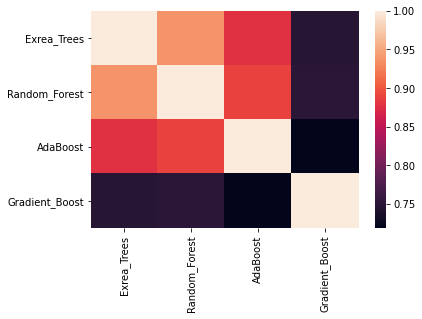

In [404]:
sns.heatmap(second_layer_train.corr())

# 如何查看模型的相关性呢？如果模型的相关性越差，则模型融合的提升就越大

In [405]:
x_train = np.concatenate([extra_tree_train, rf_train, ada_train, gb_train], axis=1)
x_test = np.concatenate([extra_tree_test, rf_test, ada_test, gb_test], axis=1)

In [408]:
print(x_train.shape)
print(x_test.shape)

(891, 4)
(418, 4)


In [409]:
# 第二层我们使用XGBoost来处理
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [417]:
# 模型融合到此结束，我们再从头好好理清下思路
# predictions

submission = pd.DataFrame({
    'PassengerId':np.arange(predictions.shape[0]),
    'Survived':predictions,
})

In [419]:
!pip3 install -U pandas

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
     |████████████████████████████████| 10.5 MB 350 kB/s eta 0:00:01�▎          | 6.9 MB 430 kB/s eta 0:00:09
  Attempting uninstall: pandas
    Found existing installation: pandas 0.25.3
    Uninstalling pandas-0.25.3:
      Successfully uninstalled pandas-0.25.3
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

civisml-extensions 0.2.1 requires pandas~=0.19; python_version >= "3.5", but you'll have pandas 1.1.0 which is incompatible.


In [421]:
submission.to_csv(r'Submission.csv')

In [423]:
pd.read_csv('Submission.csv').head()

,Unnamed: 0,PassengerId,Survived
0,0,0,0
1,1,1,1
2,2,2,0
3,3,3,0
4,4,4,1


### 提交数据

In [424]:
# 注意列不能从0到418，应该从418开始
# 一定要index=False
submission.to_csv(r'Submission.csv', index=False)

In [431]:
# pd.read_csv('Submission.csv')
# import pandas as pd
# import os
# import numpy as np

# os.chdir('/Users/mikizhu/Desktop')
# data = pd.read_csv('Submission.csv')

# data.drop(['Unnamed: 0'], axis=1, inplace=True)
# data.to_csv('Submission.csv', index=False)
# # print(pd.read_csv('test_result.csv'))

# 内容补充

## 垃圾回收机制

https://www.jianshu.com/p/b6a20c812ce4

https://www.cnblogs.com/franknihao/p/7326849.html

在平时我们往往因为计算机内存不足而不能很好地运行程序，所以我们通常要释放内存

python的垃圾回收机制就是。当一个对象没有被引用时。py就会自动释放这个数据的内存。但这样会牺牲一些效率

使用py的gc模块，进行手动垃圾回收

In [152]:
a = 1
a = 2
# 前面的1就会被释放，因为没有变量引用这个数
a = []
# 形成了循环引用，要用垃圾回收机制
b = []
a.append(b)
b.append(a)

In [153]:
import gc

# 返回循环引用释放掉的对象个数
gc.collect()
# 每次执行就会检查内存一次，将这些循环引用的对象释放

1

## KFold

这里我们单独创建一个数据集进行测试观察结果

In [200]:
d1 = {
    'xiaoming':1213,
    'xiaohong':111,
    'zhangsan':123,
    'lisi':311,
    'xiaohong':121
}
d2 = {
    'xiaoming':'a',
    'xiaohong':'b',
    'zhangsan':'c',
    'lisi':'d',
    'xiaohong':'e'
}
temp1 = pd.Series(d1)
temp2 = pd.Series(d2)
temp_train = pd.DataFrame({'date':d1,'tag':d2})
temp_train

,date,tag
xiaoming,1213,a
xiaohong,121,e
zhangsan,123,c
lisi,311,d


In [201]:
from sklearn.model_selection import KFold

In [210]:
kf = KFold(n_splits=2,shuffle=False,random_state=0)
for i in kf.split(temp_train):
    print(i)
# 注意是将序号打乱，返回的是序号

(array([2, 3]), array([0, 1]))
(array([0, 1]), array([2, 3]))


In [211]:
kf = KFold(n_splits=2,shuffle=True)
for i in kf.split(temp_train):
    print(i)

(array([0, 3]), array([1, 2]))
(array([1, 2]), array([0, 3]))


打乱其实非常有用的，可以避免数据的某些特征模型没有学习到

可以看到传回的其实只是序列号

In [212]:
kf = KFold(n_splits=2,shuffle=True)
for i,j in kf.split(temp_train):
    x1_train, x1_test = temp_train.iloc[i,:], temp_train.iloc[j,:]
    print(x1_train)
    print(x1_test)
    print('*'*20)

          date tag
xiaohong   121   e
lisi       311   d
          date tag
xiaoming  1213   a
zhangsan   123   c
********************
          date tag
xiaoming  1213   a
zhangsan   123   c
          date tag
xiaohong   121   e
lisi       311   d
********************


## 交叉验证

其实在平时的模型训练中，我们通常就是将70%作为训练集，30%作为测试集，来训练模型。这样有个缺点就是：
- 模型预测的结果好坏，很大层度上会受到数据集划分的影响

由此提出了交叉验证的方式，最常用的就是k—fold交叉验证。假如将数据划分成5部分，每一部分都会作为测试集，其他部分作为训练集。

因此最后会得到5个模型，[理论参考自知乎](https://zhuanlan.zhihu.com/p/24825503)

**k一般设置成5-10，这样可以避免模型过拟合**

**但是计算成本比较高，数据量大的时候几乎不能使用**

****
当k=数据集大小时，这时候叫做留1法。此时只有1个数据作为测试集，其他模型作为训练集

### cross_val_score

cross_val_score的作用就是打分而已，假如数据集划分成5部分，那么会得到5个分数

**作用，如果分差别比较大，那么说明模型的泛化能力比较差**

In [222]:
"""
from sklearn.model_selection import cross_val_score

clf = SVC(kernel='linear', C=1)
scores = cross_val_score(clf, x, y, cv=5) # x表示特征，y表示标签
"""

"\nfrom sklearn.model_selection import cross_val_score\n\nclf = SVC(kernel='linear', C=1)\nscores = cross_val_score(clf, x, y, cv=5) # x表示特征，y表示标签\n"

In [224]:
# 上面的cv=5表示进行5次交叉验证，默认是不会打乱顺序的，我们可以自己定义cv
"""
from sklearn.model_selection import ShuffleSplit
my_cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
scores = cross_val_score(clf, iris.data, iris.target, cv=my_cv)
"""

'\nfrom sklearn.model_selection import ShuffleSplit\nmy_cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)\nscores = cross_val_score(clf, iris.data, iris.target, cv=my_cv)\n'

参考 https://www.cnblogs.com/jiaxin359/p/8552800.html

### cross_val_predict

In [223]:
"""
from sklearn.model_selection import cross_val_predict

clf = SVC(kernel='linear', C=1)
scores = cross_val_predict(clf, x, y, cv=5) # x表示特征，y表示标签
"""

# 假如数据分成5部分，前4部分作为训练集，5部分作为测试集，先会预测出第五部分的值，最后返回所有预测结果

# 这就说明，有些部分可能会拟合的比较好，不知道模型的效果会不会有所提升

"\nfrom sklearn.model_selection import cross_val_predict\n\nclf = SVC(kernel='linear', C=1)\nscores = cross_val_predict(clf, x, y, cv=5) # x表示特征，y表示标签\n"

### 问题思考

其实像交叉验证，只是将数据集进行简单的划分，得到很多个得分而已，然而对实际的模型预测有什么实质性的帮助呢

## ShuffleSplit

参考自 https://www.cnblogs.com/jiaxin359/p/8552800.html

In [213]:
from sklearn.model_selection import ShuffleSplit

In [218]:
sf = ShuffleSplit(n_splits=3, train_size=0.8, random_state=2020)

In [219]:
for i in sf.split(temp_train):
    print(i)

(array([1, 3, 0]), array([2]))
(array([3, 1, 2]), array([0]))
(array([1, 0, 3]), array([2]))


可以看到训练集是会有重复的

## 在jupyter中使用shell

其实我们在jupyter中是可以使用shell命令的

- 只要在前面加个感叹号即可

参考自 https://zhuanlan.zhihu.com/p/83628598

## python中的解包

python中可以使用* and \** 进行解包，双星号是解包字典，由于字典是无序的，所以在使用的时候，参数会在字典中进行匹配，然后炸开字典，把值一一传给参数

In [327]:
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

In [328]:
class A:
    def __init__(self, C, kernel):
        print(kernel, C)
        
a = A(**svc_params)  

linear 0.025


In [323]:
def test(kernel, C):
    print(kernel,C)

test(**svc_params)

linear 0.025


# 参考资料

1. 资料比较全，包括了所有机器学习部分的讲解，还有stacking和面试等知识，方便查阅
https://www.jianshu.com/p/28f02bb59fe5
2. https://www.cnblogs.com/jiaxin359/ 这个人写的比较详细，可以看看

# 待解决问题

- 在对连续型数据进行填充时，使用中位数填充还是平均数填充

# TODO